In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aroojzahra","key":"a872123416faa088384afea314a1ee79"}'}

In [3]:
# create a kaggle directory

!mkdir ~/.kaggle


In [4]:
# copy the kaggle.json to created the folder
!cp kaggle.json ~/.kaggle/

In [5]:
# permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# to list all the datasets in kaggle
!kaggle datasets list

ref                                                          title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
haseebindata/student-performance-predictions                 Student Performance Predictions                     9KB  2024-08-17 06:57:57           8393        181  0.9411765        
lainguyn123/student-performance-factors                      Student Performance Factors                        94KB  2024-09-02 10:53:57           2093         50  1.0              
lainguyn123/employee-survey                                  Employee Survey                                    61KB  2024-09-03 09:46:24            945         23  1.0              
krupalpatel07/pepsico-daily-data                             PEPSICO Daily Data      

In [7]:
!kaggle datasets download -d mohit3430/haze1k


Dataset URL: https://www.kaggle.com/datasets/mohit3430/haze1k
License(s): unknown
100% 953M/953M [00:45<00:00, 24.0MB/s]
100% 953M/953M [00:45<00:00, 21.8MB/s]


In [8]:
!unzip haze1k.zip -d ./haze1k


Archive:  haze1k.zip
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/001.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/002.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/003.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/004.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/005.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/006.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/007.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/008.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/009.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/010.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/011.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/012.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/013.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/i

In [9]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [10]:
PATH_HAZE = '/content/haze1k/Distributed_haze1k/'
PATH_RICE = '/kaggle/input/rice-1/RICE_SPLIT/'
PATH = PATH_HAZE

In [11]:
BATCH_SIZE = 4
image_shape = (256,256,3)

In [12]:
def load_image(image_path):
    '''Load and preprocess the image'''
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = (img / 127.5) - 1.0

    return img

def load_paired_data(real_image_path, fake_image_path):
    real_image = load_image(real_image_path)
    fake_image = load_image(fake_image_path)

    return real_image, fake_image

In [13]:
def load_dataset(PATH, test_ds = False):
    haze_images_paths = os.listdir(PATH + 'input')
    haze_images_paths = [PATH + 'input/'+  item   for item in haze_images_paths]
    haze_images_paths.sort()
#     if len(haze_images_paths) >= 100:
#         haze_images_paths = haze_images_paths[:100]


    clear_images_paths = os.listdir(PATH + 'target')
    clear_images_paths = [PATH + 'target/'+  item   for item in clear_images_paths]
    clear_images_paths.sort()
#     if len(clear_images_paths) >=100:
#         clear_images_paths = clear_images_paths[:100]


    dataset = tf.data.Dataset.from_tensor_slices((haze_images_paths, clear_images_paths))
    dataset = dataset.map(load_paired_data, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    if test_ds == True:
        dataset = dataset.batch(1)
        return dataset

    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [14]:
train_ds = load_dataset(PATH + 'train/')


In [15]:
print(len(train_ds))

225


In [16]:
def subplot(img1, img2, title1, title2):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    img1 = (img1[0] + 1) / 2.0
    img2 = (img2[0] + 1) / 2.0

    axes[0].imshow(img1)
    axes[0].set_title(title1)
    axes[0].axis('off')

    axes[1].imshow(img2)
    axes[1].set_title(title2)
    axes[1].axis('off')
    plt.show()

(4, 256, 256, 3)


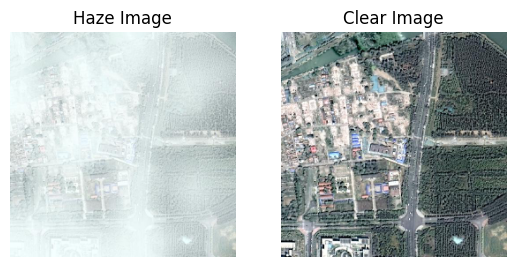

In [24]:
haze_image, clear_image  = next(iter(train_ds))
print(haze_image.shape)
subplot(haze_image, clear_image, 'Haze Image', 'Clear Image')

In [25]:
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [64]:
class InceptionBlock(layers.Layer):
    def __init__(self, f, pooling=True):
        super(InceptionBlock, self).__init__()

        self.f = f
        self.pooling = pooling

        '''===PATH1==='''
        self.conva0 = layers.Conv2D(self.f, (1, 1), activation='relu', padding='same')
        self.batch_norma0 = layers.BatchNormalization()
        self.conva1 = layers.Conv2D(self.f, (3, 3), activation='relu', padding='same')
        self.batch_norma1 = layers.BatchNormalization()
        self.conva2 = layers.Conv2D(self.f, (1, 3), activation='relu', padding='same')
        self.batch_norma2 = layers.BatchNormalization()
        self.poola = layers.MaxPooling2D(pool_size=(2, 2))
        self.conva3 = layers.Conv2D(self.f, (3, 1), activation='relu', padding='same')
        self.batch_norma3 = layers.BatchNormalization()
        self.concat1 = layers.Concatenate(axis=-1)
        self.poola = layers.MaxPooling2D(pool_size=(2, 2))

        '''===PATH2==='''
        self.convb0 = layers.Conv2D(self.f, (1, 1), activation = 'relu', padding = 'same')
        self.batch_normb0 = layers.BatchNormalization()
        self.convb1 = layers.Conv2D(self.f, (1, 3), activation='relu', padding='same')
        self.batch_normb1 = layers.BatchNormalization()
        self.convb2 = layers.Conv2D(self.f, (3, 1), activation='relu', padding='same')
        self.batch_normb2 = layers.BatchNormalization()
        self.poolb = layers.MaxPooling2D(pool_size=(2, 2))
        self.concat2 = layers.Concatenate(axis=-1)

        '''===PATH3==='''
        self.ppoolc = layers.MaxPooling2D(pool_size=(3,3), strides=(1, 1), padding='same')
        self.convc0 = layers.Conv2D(self.f, (1, 1), activation='relu', padding='same')
        self.batch_normc0 = layers.BatchNormalization()
        self.poolc = layers.MaxPooling2D(pool_size=(2, 2))

        '''===PATH4==='''
        self.convd1 = layers.Conv2D(self.f, (1, 1), activation='relu', padding='same')
        self.batch_normd1 = layers.BatchNormalization()
        self.poold = layers.MaxPooling2D(pool_size=(2, 2))

        self.concat = layers.Concatenate(axis=-1)

    def call(self, inputs, training=False):
        conva = self.conva0(inputs) #1x1
        conva = self.batch_norma0(conva, training=training)
        conva = self.conva1(conva)  #3x3
        conva = self.batch_norma1(conva, training=training)
        conva_con1 = self.conva2(conva) # 1x3
        conva_con1 = self.batch_norma2(conva_con1, training=training)
        conva_con2 = self.conva3(conva) # 3x1
        conva_con2 = self.batch_norma3(conva_con2, training=training)
        conva = self.concat1([conva_con1, conva_con2])
        if self.pooling:
            conva = self.poola(conva)

        convb = self.convb0(inputs) # 1x1
        convb = self.batch_normb0(convb, training=training)
        convb_con1 = self.convb1(convb) # 1x3
        convb_con1 = self.batch_normb1(convb_con1, training=training)
        convb_con2 = self.convb2(convb) # 3x1
        convb_con2 = self.batch_normb2(convb_con2, training=training)
        convb = self.concat([convb_con1, convb_con2])
        if self.pooling:
            convb = self.poolb(convb)

        convc = self.ppoolc(inputs)
        convc = self.convc0(convc)
        convc = self.batch_normc0(convc, training=training)
        if self.pooling:
            convc = self.poolc(convc)

        convd = self.convd1(inputs)
        convd = self.batch_normd1(convd, training=training)
        if self.pooling:
            convd = self.poold(convd)

        up = self.concat([conva, convb, convc, convd])
        return up

In [65]:
class Generator(Model):
    def __init__(self):
        super(Generator, self).__init__()

        self.init = tf.keras.initializers.RandomNormal(stddev=0.02, seed=123)

        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool1 = layers.MaxPooling2D(pool_size=(2, 2))

        self.conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.pool2 = layers.MaxPooling2D(pool_size=(2, 2))

        self.conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')
        self.conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')
        self.pool3 = layers.MaxPooling2D(pool_size=(2, 2))

        self.conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')
        self.conv8 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')
        self.pool4 = layers.MaxPooling2D(pool_size=(2, 2))

        self.conv9 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')
        self.conv10 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')

        self.i1 = InceptionBlock(128, False)
        self.i2 = InceptionBlock(128, True)
        self.i3 = InceptionBlock(128, True)
        self.i4 = InceptionBlock(128, True)

        self.up6 = layers.Concatenate(axis=-1)
        self.conv11 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')
        self.conv12 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')

        self.up7 = layers.Concatenate(axis=-1)
        self.conv13 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')
        self.conv14 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')

        self.up8 = layers.Concatenate(axis=-1)
        self.conv15 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.conv16 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')

        self.up9 = layers.Concatenate(axis=-1)
        self.conv17 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.conv18 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')

        self.conv19 = layers.Conv2D(3, (1, 1), activation='tanh')

        self.convT1 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')
        self.convT2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')
        self.convT3 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')
        self.convT4 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')

    def call(self, batch):
        conv1 = self.conv1(batch)
        conv1 = self.conv2(conv1)
        pool1 = self.pool1(conv1)

        conv2 = self.conv3(pool1)
        conv2 = self.conv4(conv2)
        pool2 = self.pool2(conv2)

        conv3 = self.conv5(pool2)
        conv3 = self.conv6(conv3)
        pool3 = self.pool3(conv3)

        conv4 = self.conv7(pool3)
        conv4 = self.conv8(conv4)
        pool4 = self.pool4(conv4)

        conv5 = self.conv9(pool4)
        conv5 = self.conv10(conv5)

        i1 = self.i1(batch)
        i2 = self.i2(i1)
        i3 = self.i3(i2)
        i4 = self.i4(i3)

        up6 = self.up6([self.convT1(conv5), conv4, i4])
        conv6 = self.conv11(up6)
        conv6 = self.conv12(conv6)

        up7 = self.up7([self.convT2(conv6), conv3, i3])
        conv7 = self.conv13(up7)
        conv7 = self.conv14(conv7)

        up8 = self.up8([self.convT3(conv7), conv2, i2])
        conv8 = self.conv15(up8)
        conv8 = self.conv16(conv8)

        up9 = self.up9([self.convT4(conv8), conv1, i1])
        conv9 = self.conv17(up9)
        conv9 = self.conv18(conv9)

        conv10 = self.conv19(conv9)
        return conv10


    def build_summary(self, input_shape=image_shape):
        inp = Input(shape = input_shape)
        return Model(inputs = [inp], outputs = self.call(inp))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'inception_block_24', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'inception_block_25', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'inception_block_26', howeve

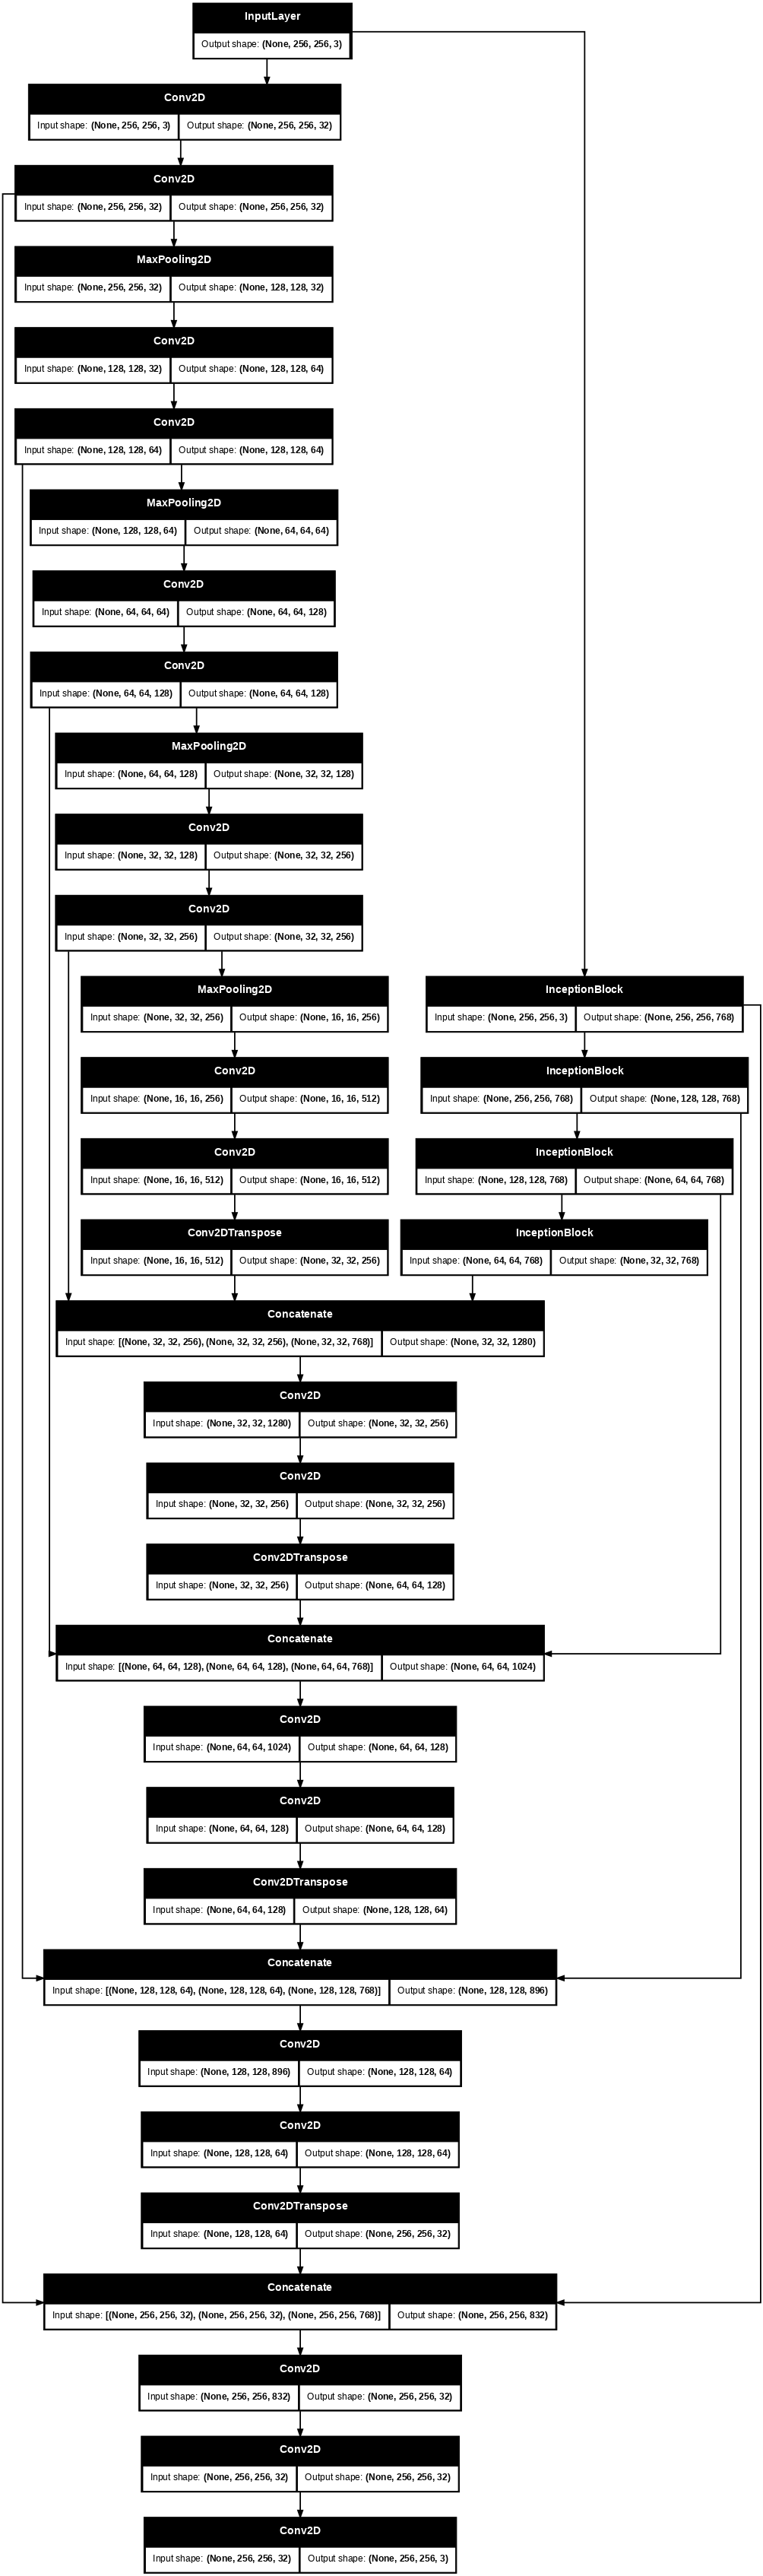

In [40]:
generator = Generator()
tf.keras.utils.plot_model(generator.build_summary(), show_shapes=True, dpi=64)

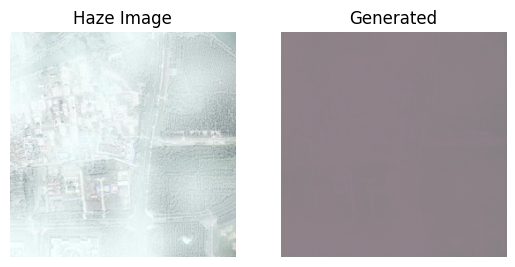

In [41]:
gen_output = generator(haze_image)

subplot(haze_image, gen_output, 'Haze Image', 'Generated')

In [42]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [43]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.init = tf.keras.initializers.RandomNormal(stddev=0.02, seed=123)

        self.concat = layers.Concatenate()

        self.conv1 = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=self.init)
        self.leaky_relu1 = layers.LeakyReLU(alpha=0.2)

        self.conv2 = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=self.init)
        self.batch_norm2 = layers.BatchNormalization()
        self.leaky_relu2 = layers.LeakyReLU(alpha=0.2)

        self.conv3 = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=self.init)
        self.batch_norm3 = layers.BatchNormalization()
        self.leaky_relu3 = layers.LeakyReLU(alpha=0.2)

        self.conv4 = layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=self.init)
        self.batch_norm4 = layers.BatchNormalization()
        self.leaky_relu4 = layers.LeakyReLU(alpha=0.2)

        self.conv5 = layers.Conv2D(512, (4, 4), padding='same', kernel_initializer=self.init)
        self.batch_norm5 = layers.BatchNormalization()
        self.leaky_relu5 = layers.LeakyReLU(alpha=0.2)

        self.conv6 = layers.Conv2D(1, (4, 4), padding='same', kernel_initializer=self.init)
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, inp, tar):
        x = self.concat([inp, tar])

        x = self.conv1(x)
        x = self.leaky_relu1(x)

        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.leaky_relu2(x)

        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.leaky_relu3(x)

        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = self.leaky_relu4(x)

        x = self.conv5(x)
        x = self.batch_norm5(x)
        x = self.leaky_relu5(x)

        x = self.conv6(x)
        patch_out = self.sigmoid(x)

        return patch_out

    def build_summary(self, input_shape=(256,256,3)):
        inp = Input(shape = input_shape)
        tar = Input(shape = input_shape)
        return Model(inputs = [inp, tar], outputs = self.call(inp, tar))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


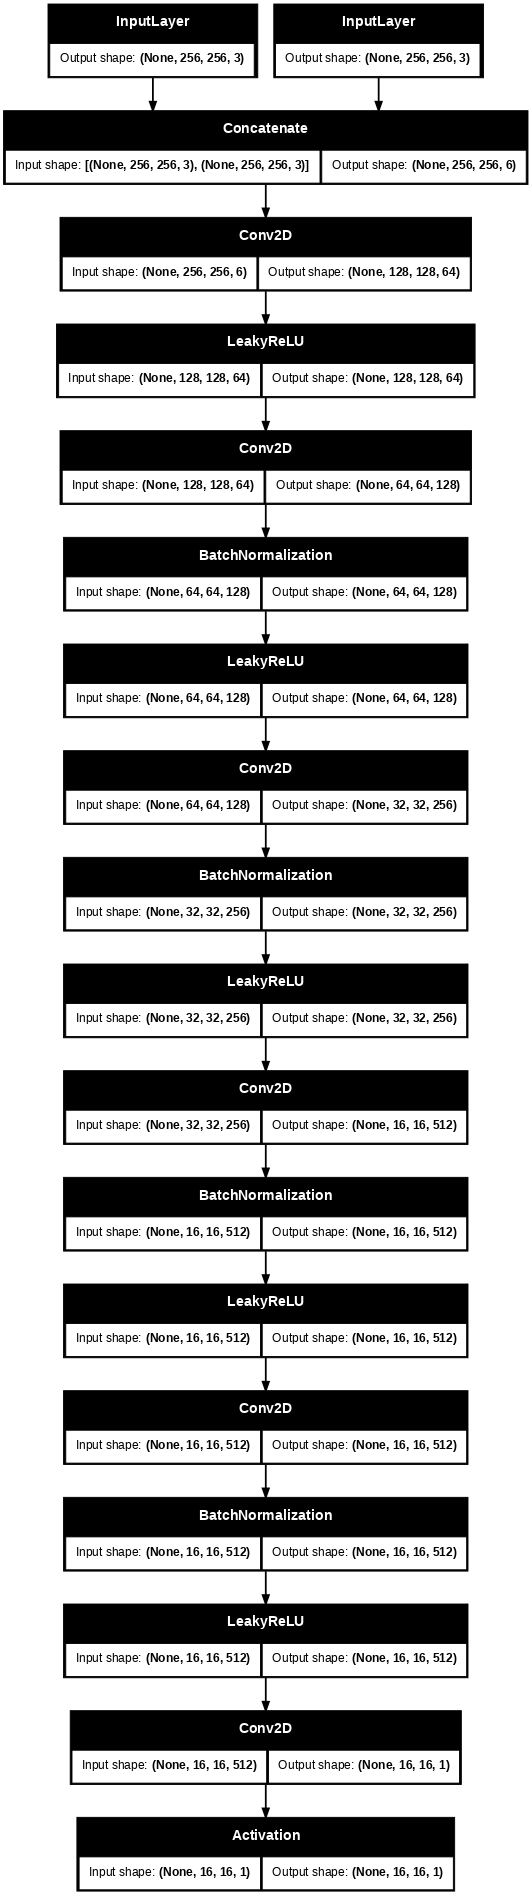

In [44]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator.build_summary(image_shape), show_shapes=True, dpi=64)

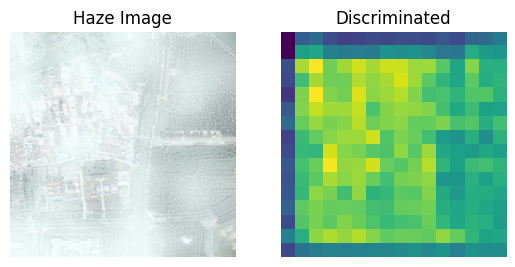

In [45]:
disc_output = discriminator(gen_output, haze_image)

subplot(haze_image, disc_output, 'Haze Image', 'Discriminated')

In [46]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [47]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [48]:
class Pix2Pix(Model):
    def __init__(
        self,
        clear_generator,
        clear_discriminator,
    ):
        super(Pix2Pix, self).__init__()
        self.c_gen = clear_generator
        self.c_disc = clear_discriminator

    def compile(
        self,
        c_gen_optimizer,
        c_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(Pix2Pix, self).compile()
        self.c_gen_optimizer = generator_optimizer
        self.c_disc_optimizer = discriminator_optimizer
        self.gen_loss_fn = generator_loss
        self.disc_loss_fn = discriminator_loss

    def train_step(self, batch_data):
        haze, clear = batch_data

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = generator(haze, training=True)

            disc_real_output = discriminator(haze, clear, training=True)
            disc_generated_output = discriminator(haze, gen_output, training=True)

            gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, clear)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(
            gen_total_loss, generator.trainable_variables
        )
        discriminator_gradients = disc_tape.gradient(
            disc_loss, discriminator.trainable_variables
        )

        generator_optimizer.apply_gradients(
            zip(generator_gradients, generator.trainable_variables)
        )
        discriminator_optimizer.apply_gradients(
            zip(discriminator_gradients, discriminator.trainable_variables)
        )

        return {
            'gen_total_loss': gen_total_loss,
            'gen_gan_loss' : gen_gan_loss,
            'gen_l1_loss' : gen_l1_loss,
            'disc_loss' : disc_loss
        }


In [49]:
moderate_test_ds = load_dataset(PATH + 'test_moderate/')


In [50]:
inp_img, tar_img = next(iter(moderate_test_ds))
def save_images(gen, test_input, name, step):
    pred_by_gen = gen(test_input)

    test_input = (test_input[0]+ 1)/2.0
    pred_by_gen = (pred_by_gen[0]+1)/2.0

    plt.figure(figsize=(12, 12))

    display_list = [test_input, pred_by_gen]
    title = ['Input Image', 'Generated Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')

    filename = '%s_generated_plot_%06d.png' % (name, (step+1))
    plt.savefig(filename)
    plt.close()

In [51]:
class ReportCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1)%5 == 0:
            save_images(generator, inp_img, 'CtoH', epoch)

In [52]:
from tensorflow.keras.callbacks import CSVLogger
callbacks = [
    CSVLogger('training_res.csv'),  # Using current directory
    ReportCallback()
]


In [53]:
pix2pix_gan = Pix2Pix(generator, discriminator)

pix2pix_gan.compile(c_gen_optimizer=generator_optimizer,
                  c_disc_optimizer=discriminator_optimizer,
                  gen_loss_fn=generator_loss,
                  disc_loss_fn=discriminator_loss)

In [54]:
%%time
hist = pix2pix_gan.fit(train_ds, epochs=5,batch_size = BATCH_SIZE, callbacks=callbacks,verbose=1)

Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - disc_loss: 1.3032 - gen_gan_loss: 0.9932 - gen_l1_loss: 0.2140 - gen_total_loss: 22.3916
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - disc_loss: 1.3148 - gen_gan_loss: 0.8589 - gen_l1_loss: 0.1818 - gen_total_loss: 19.0371
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - disc_loss: 1.3574 - gen_gan_loss: 0.8013 - gen_l1_loss: 0.1591 - gen_total_loss: 16.7127
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - disc_loss: 1.3763 - gen_gan_loss: 0.7395 - gen_l1_loss: 0.1436 - gen_total_loss: 15.0967
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - disc_loss: 1.3610 - gen_gan_loss: 0.7497 - gen_l1_loss: 0.1316 - gen_total_loss: 13.9109
CPU times: user 23min 6s, sys: 8.63 s, total: 23min 15s
Wall time: 23min 39s


In [57]:
generator.save('generator_model.h5')

In [69]:
loaded_generator = tf.keras.models.load_model('/content/generator_model.h5')

ValueError: Unknown layer: 'Generator'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
ssim_list = []
psnr_list = []

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def ssim_evaluation(img1, img2):
    ssim_value = ssim(img1, img2, channel_axis=2, data_range=img2.max() - img2.min())
    ssim_list.append(ssim_value)

def psnr_evaluation(img1, img2):
    psnr_value = psnr(img1,img2)
    psnr_list.append(psnr_value)

In [ ]:
def evaluate_model(model, inp, tar, sno):
    pred = model(inp, training=True)
    plt.figure(figsize=(15, 15))

    inp = inp[0].numpy()
    inp = (inp + 1)/2.0
    tar = tar[0].numpy()
    tar = (tar + 1)/2.0
    pred = pred[0].numpy()
    pred = (pred + 1)/2.0

    ## ssim
    ssim_curr = ssim_evaluation(tar, pred)

    ## psnr
    psnr_curr = psnr_evaluation(tar, pred)

    display_list = [inp, tar, pred]
    title = ['Haze Image', 'Ground Truth', 'Predicted Image']

    if sno<=5:
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()
    plt.close()



In [ ]:
import pandas as pd
skeleton = {
        'SSIM': [],
        'PSNR': []
}

In [ ]:
import statistics

def evaluate_test(test_ds, name):
    for i, (inp, tar) in test_ds.take(len(test_ds)).enumerate():
        evaluate_model(loaded_generator, inp, tar, i)

    ssim_mean = statistics.mean(ssim_list)
    psnr_mean = statistics.mean(psnr_list)

    print('Dataset-{}'.format(name))
    print(ssim_mean)
    print(psnr_mean)


    skeleton['SSIM'].append(ssim_mean)
    skeleton['PSNR'].append(psnr_mean)

    ssim_list.clear()
    psnr_list.clear()


In [ ]:
evaluate_test(moderate_test_ds, 'Moderate')
evaluate_test(thick_test_ds, 'Thick')
evaluate_test(thin_test_ds, 'Thin')

In [ ]:
df_res = pd.DataFrame(skeleton, index = ["Mod", "Thick", "Thin"])
df_res

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

# Load and preprocess the image
def load_image(image_path, target_size=(256, 256)):
    image = Image.open(image_path).resize(target_size)
    image = np.array(image).astype(np.float32) / 127.5 - 1.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Post-process the image
def postprocess_image(image):
    image = (image + 1.0) * 127.5
    image = np.clip(image, 0, 255).astype(np.uint8)
    return image[0]

# Define the path to your image
input_image_path = 'path_to_your_image.jpg'  # Replace with your image path

# Load the image
input_image = load_image(input_image_path)

# Generate output from the Pix2Pix model
generated_image = loaded_generator(input_image, training=False)

# Post-process images
input_image = postprocess_image(input_image)
generated_image = postprocess_image(generated_image)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(input_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Generated Image')
plt.imshow(generated_image)
plt.axis('off')

plt.show()


In [ ]:
import tensorflow as tf

# Assuming you have a trained generator and discriminator model
# Replace `generator` and `discriminator` with your actual model variables

# Save paths
generator_model_path_d_drive = 'D:/models/generator_modell.h5'
discriminator_model_path_d_drive = 'D:/models/discriminator_model.h5'

generator_model_path_current_dir = 'generator_model.h5'
discriminator_model_path_current_dir = 'discriminator_model.h5'

# Save the models
generator.save(generator_model_path_d_drive)
discriminator.save(discriminator_model_path_d_drive)

generator.save(generator_model_path_current_dir)
discriminator.save(discriminator_model_path_current_dir)


In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model
generator_model_path = 'D:/models/generator_modell.h5'  # or use current directory path
generator = tf.keras.models.load_model(generator_model_path)

# Function to preprocess the image
def preprocess_image(image_path, target_size):
    image = Image.open(image_path).convert('RGB')  # Open image and ensure it's in RGB
    image = image.resize(target_size)  # Resize to match model input size
    image_array = np.array(image) / 255.0  # Convert to array and normalize
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    return image_array

# Function to post-process the output
def postprocess_image(output_array):
    output_array = output_array.squeeze()  # Remove batch dimension
    output_array = (output_array * 255.0).astype(np.uint8)  # Rescale to 0-255
    return output_array

# Load and preprocess the input image
input_image_path = 'path/to/your/image.jpg'
target_size = (256, 256)  # Replace with your model's input size
preprocessed_image = preprocess_image(input_image_path, target_size)

# Make prediction
predicted_image = generator.predict(preprocessed_image)

# Post-process the predicted image
postprocessed_image = postprocess_image(predicted_image[0])

# Display the results
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
original_image = Image.open(input_image_path)
plt.imshow(original_image)
plt.title('Original Image')

# Predicted image
plt.subplot(1, 2, 2)
plt.imshow(postprocessed_image)
plt.title('Haze Removed Image')

plt.show()
